## Standard Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
import string
import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader

## Importing Data

In [5]:
with open("./data/yelp_labelled.txt") as f:
    reviews = f.read()
yelp = pd.DataFrame([review.split('\t') for review in reviews.split('\n')])
yelp.columns = ['review','sentiment']
yelp.head()

,review,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [6]:
yelp = yelp.drop(1000,axis = 0)

## Exploratory Data Analysis

In [7]:
yelp['length'] = yelp['review'].apply(len)

In [8]:
yelp.describe()

,length
count,1000.000000
mean,58.320000
std,32.366699
min,11.000000
25%,33.000000
50%,51.000000
75%,80.000000
max,149.000000


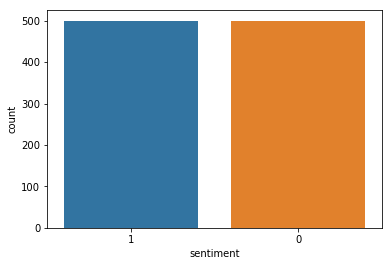

In [9]:
sns.countplot(x = 'sentiment',data = yelp)

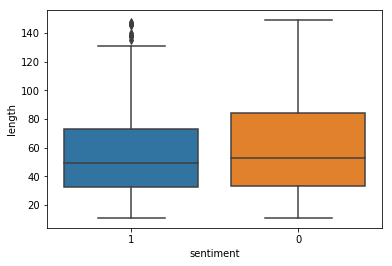

In [10]:
sns.boxplot(x = 'sentiment',y = 'length',data = yelp)

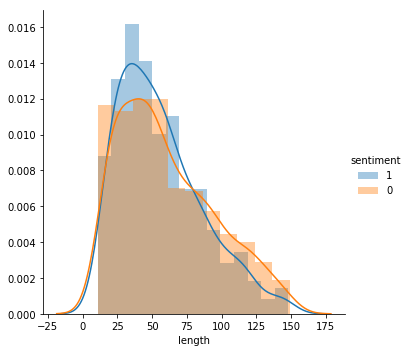

In [11]:
g = sns.FacetGrid(yelp,hue = 'sentiment',size = 5)
g.map(sns.distplot,'length')
g.add_legend()

Negative Reviews tend to be longer !!

## Tokenizing Reviews and Setting up Vocabulary

In [12]:
from nltk.tokenize import word_tokenize

In [13]:
def text_preprocessing(data):
    texts = list(data['review'].values)
    clean_text = []
    for i in texts:
        clean_text.append(i.translate(str.maketrans('','',string.punctuation)).lower().rstrip())
    tokenized = [word_tokenize(x) for x in clean_text]
    all_text = set()
    for tokens in tokenized:
        for words in tokens:
            all_text.add(words)
    return tokenized,all_text

In [14]:
reviews,vocab = text_preprocessing(yelp)

In [15]:
reviews[0]

['wow', 'loved', 'this', 'place']

## Mapping Vocabulary Words with Indexes and vice-versa

In [16]:
def mapp_words(words):
    word_to_int = {w:i+1 for i,w in enumerate(words)}
    int_to_word = {i:w for w,i in word_to_int.items()}
    return word_to_int,int_to_word

In [17]:
word_to_int,int_to_word = mapp_words(vocab)

## Padding Reviews

In [18]:
def pad_text(tokenized_reviews,seq_length):
    reviews = []
    for review in tokenized_reviews:
        if len(review) >= seq_length:
            reviews.append(review[:seq_length])
        else:
            reviews.append(['']*(seq_length - len(review)) + review)
    return np.array(reviews)

In [19]:
padded_reviews = pad_text(reviews,75)

In [20]:
padded_reviews[5]

array(['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', 'now', 'i',
       'am', 'getting', 'angry', 'and', 'i', 'want', 'my', 'damn', 'pho'],
      dtype='<U33')

Giving index 0 to empty string ""

In [21]:
word_to_int[""] = 0
int_to_word[0] = ""

## Encoding Reviews

In [22]:
encoded_reviews = np.array([[word_to_int[word] for word in review] for review in padded_reviews])

In [23]:
encoded_reviews[3]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,   34, 1227, 2053,  961, 1511, 1384,
        508,  873,  102, 1765,  192,  228,  632,  540,  295])

## Defining LSTM Model,Loss and Optimizing Function

In [24]:
class Model(nn.Module):
    def __init__(self, n_vocab, n_embed, n_hidden, n_output, n_layers, drop_p = 0.8):
        super().__init__()
        self.n_vocab = n_vocab  
        self.n_layers = n_layers 
        self.n_hidden = n_hidden 
        self.embedding = nn.Embedding(n_vocab, n_embed)
        self.lstm = nn.LSTM(n_embed, n_hidden, n_layers, batch_first = True, dropout = drop_p)
        self.dropout = nn.Dropout(drop_p)
        self.fc = nn.Linear(n_hidden, n_output)
        self.sigmoid = nn.Sigmoid()
    def forward (self,X):                
        embedded_words = self.embedding(X)
        lstm_out, h = self.lstm(embedded_words) 
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.n_hidden)
        fc_out = self.fc(lstm_out)                  
        sigmoid_out = self.sigmoid(fc_out)              
        sigmoid_out = sigmoid_out.view(batch_size, -1)  
        sigmoid_last = sigmoid_out[:, -1]
        return sigmoid_last, h
    def init_hidden (self, batch_size):
        device = "cuda"
        weights = next(self.parameters()).data
        h = (weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
             weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        return h

In [25]:
n_vocab = len(word_to_int)
n_embed = 75
n_hidden = 150
n_output = 1
n_layers = 2

In [26]:
model = Model(n_vocab, n_embed, n_hidden, n_output, n_layers).cuda()

In [27]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

## Train,Test Split

In [28]:
labels = np.array([int(x) for x in yelp['sentiment'].values])

In [29]:
train_ratio = 0.8
valid_ratio = (1 - train_ratio)/2
total = len(encoded_reviews)
train_cutoff = int(total * train_ratio)
valid_cutoff = int(total * (1 - valid_ratio))

In [30]:
train_x, train_y = torch.Tensor(encoded_reviews[:train_cutoff]).long().cuda(), torch.Tensor(labels[:train_cutoff]).long().cuda()
valid_x, valid_y = torch.Tensor(encoded_reviews[train_cutoff : valid_cutoff]).long().cuda(), torch.Tensor(labels[train_cutoff : valid_cutoff]).long().cuda()
test_x, test_y = torch.Tensor(encoded_reviews[valid_cutoff:]).long().cuda(), torch.Tensor(labels[valid_cutoff:]).long().cuda()

In [32]:
train_x

SyntaxError: invalid syntax (<ipython-input-32-0881fb5d22dd>, line 1)

In [30]:
train_data = TensorDataset(train_x, train_y)
valid_data = TensorDataset(valid_x, valid_y)
test_data = TensorDataset(test_x, test_y)

In [31]:
batch_size = 1
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

## Training the model

In [32]:
import time 
start = time.time()
epochs = 10
clip = 5
train_loss = []
valid_loss = []
train_correct = []
valid_correct = []
for e in range(epochs):
    trn_cor = 0
    vld_cor = 0
    for b,(X_train,Y_train) in enumerate(train_loader): 
            model.zero_grad()
            Y_pred, h = model(X_train)
            loss = criterion(Y_pred.squeeze(), Y_train.float())
            preds = torch.round(Y_pred.squeeze())
            correct_tensor = preds.eq(Y_train.float().view_as(preds)).cpu()
            trn_cor += np.sum(np.squeeze(correct_tensor.numpy()))
            if ((b+1) % 200) == 0:
                print(f"Epoch:{e+1} Batch:{b+1} [{(b+1)*1}/{800}] Loss : {loss.item():.8f} Accuracy : {(trn_cor.item()/(b+1))*100:.4f}%")
            loss.backward()
            nn.utils.clip_grad_norm(model.parameters(), clip)
            optimizer.step()
    train_loss.append(loss.item())
    train_correct.append(trn_cor)
    with torch.no_grad():
        for X_test,Y_test in valid_loader:
            Y_val, v_h = model(X_test)
            v_loss = criterion(Y_val.squeeze(),Y_test.float())
            preds = torch.round(Y_val.squeeze())
            correct_tensor = preds.eq(Y_test.float().view_as(preds)).cpu()
            vld_cor += np.sum(np.squeeze(correct_tensor.numpy()))
        valid_loss.append(v_loss.item())
        valid_correct.append(vld_cor)
end = time.time()
dur = end-start
print(f'Training Duration : {int(dur/60)} minutes and {int(dur%60)} seconds')

Epoch:1 Batch:200 [200/800] Loss : 0.49018297 Accuracy : 55.0000%
Epoch:1 Batch:400 [400/800] Loss : 0.68635511 Accuracy : 55.7500%
Epoch:1 Batch:600 [600/800] Loss : 0.81111509 Accuracy : 55.8333%
Epoch:1 Batch:800 [800/800] Loss : 1.55398858 Accuracy : 57.7500%
Epoch:2 Batch:200 [200/800] Loss : 0.20935562 Accuracy : 73.5000%
Epoch:2 Batch:400 [400/800] Loss : 0.17457959 Accuracy : 73.2500%
Epoch:2 Batch:600 [600/800] Loss : 0.12602392 Accuracy : 72.1667%
Epoch:2 Batch:800 [800/800] Loss : 0.54308349 Accuracy : 73.0000%
Epoch:3 Batch:200 [200/800] Loss : 3.79615617 Accuracy : 81.5000%
Epoch:3 Batch:400 [400/800] Loss : 0.00925663 Accuracy : 82.2500%
Epoch:3 Batch:600 [600/800] Loss : 0.16339934 Accuracy : 82.6667%
Epoch:3 Batch:800 [800/800] Loss : 0.11005514 Accuracy : 82.7500%
Epoch:4 Batch:200 [200/800] Loss : 0.04334629 Accuracy : 90.0000%
Epoch:4 Batch:400 [400/800] Loss : 0.00480212 Accuracy : 91.0000%
Epoch:4 Batch:600 [600/800] Loss : 0.02008215 Accuracy : 90.5000%
Epoch:4 Ba

## Comparing Training and Validation Metrics

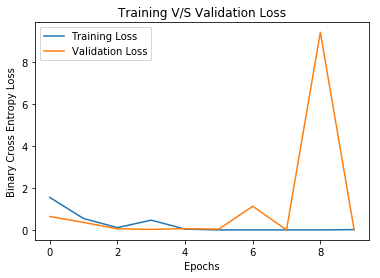

In [33]:
plt.plot([i for i in range(epochs)],train_loss,label = 'Training Loss')
plt.title('Training V/S Validation Loss')
plt.xlabel('Epochs')
plt.ylabel("Binary Cross Entropy Loss")
plt.plot([i for i in range(epochs)],valid_loss,label = 'Validation Loss')
plt.legend();

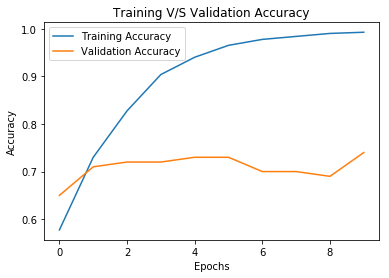

In [34]:
plt.plot([i for i in range(epochs)],[i/800 for i in train_correct],label = 'Training Accuracy')
plt.title('Training V/S Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.plot([i for i in range(epochs)],[i/100 for i in valid_correct],label = 'Validation Accuracy')
plt.legend();

## Saving Model

In [35]:
torch.save(model.state_dict(),'./model.pkl')

From here onwards we will load the model

In [36]:
# model = SentimentLSTM(n_vocab, n_embed, n_hidden, n_output, n_layers).cuda()
# model.load_state_dict(torch.load('model.pkl'))

## Testing the Model

In [37]:
test_total = []
pred_total = []
test_loss = []
with torch.no_grad():
        for X_test,Y_test in test_loader:
            test_total.append(Y_test)
            Y_val, t_h = model(X_test)
            t_loss = criterion(Y_val.squeeze(),Y_test.float())
            preds = torch.round(Y_val.squeeze())
            pred_total.append(preds)
            test_loss.append(t_loss.item())

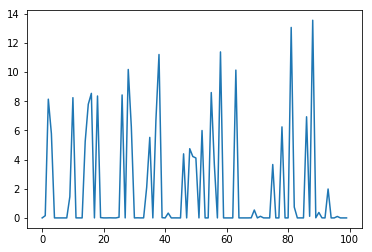

In [38]:
plt.plot(test_loss)

In [49]:
from sklearn.metrics import classification_report

In [44]:
test_total = torch.tensor(test_total)
pred_total = torch.tensor(pred_total)

In [50]:
test_total = test_total.numpy()
pred_total = pred_total.numpy().astype(np.int64)

In [57]:
print(classification_report(test_total,pred_total))

              precision    recall  f1-score   support

           0       0.97      0.70      0.81        96
           1       0.06      0.50      0.11         4

   micro avg       0.69      0.69      0.69       100
   macro avg       0.52      0.60      0.46       100
weighted avg       0.93      0.69      0.78       100



We got unusual results as our test data contained only 4 positive reviews !!

In [58]:
conf = pd.crosstab(test_total,pred_total,rownames=['Actual'],colnames=['Predicted'],margins = True)

In [59]:
conf

Predicted,0,1,All
Actual,,,
0,67,29,96
1,2,2,4
All,69,31,100


## Predicting Unknown Reviews

Applying same preprocessing techniques to the unknown review

In [60]:
def preprocess_review(review):
    review = review.translate(str.maketrans('', '',string.punctuation)).lower().rstrip()
    tokenized = word_tokenize(review)
    if len(tokenized) >= 75:
        review = tokenized[:75]
    else:
        review= ['0']*(75-len(tokenized)) + tokenized
    final = []
    for token in review:
        try:
            final.append(word_to_int[token])
        except:
            final.append(word_to_int[''])
    return final

In [74]:
def predict(review):
    model.eval()
    words = np.array([preprocess_review(review)])
    padded_words = torch.from_numpy(words).cuda().long()
    pred_loader = DataLoader(padded_words, batch_size = 1, shuffle = True)
    for x in pred_loader:
        output = model(x)[0].item()
    msg = "This is a positive review." if output >= 0.5 else "This is a negative review."
    print(msg)
    print('Prediction = ' + str(output))

In [81]:
predict("I enjoyed it pretty much")

This is a positive review.
Prediction = 0.9981502294540405


In [82]:
predict("It was a waste of time")

This is a negative review.
Prediction = 4.699601777247153e-05
